# Configurando experimento

In [1]:
import sys
sys.path.append('..')
from config import *
import pandas as pd
import datetime
import pickle
import os
from tqdm import tqdm

sys.path.append('../..')
from src.model.weather_pert import WeatherPert
from src.model.true import check_duration
from joblib import Parallel, delayed
from src.validation.validation import *


In [2]:

B = 20_000
month_var = 'month'
doy_var = 'doy'

date_train_start = datetime.date(2017, 1, 1)
date_train_end = datetime.date(2017, 12, 31)
date_train = [(date_train_start+datetime.timedelta(days=x)).isoformat() for x in range(0, (date_train_end-date_train_start).days+1, 7)]
print('date_train', date_train)

date_test_start = datetime.date(2019, 1, 1)
date_test_end = datetime.date(2020, 12, 31)
date_test = [(date_test_start+datetime.timedelta(days=x)).isoformat() for x in range(0, (date_test_end-date_test_start).days+1, 7)]
print('date_test', date_test)

loss_type = 'right-tail'

weather_pert_hpt = []
for alpha in [0.95, 1.]:
    for smoothing in [3, 7, 14]:
        if smoothing >= 3:
            mcs = [True, False]
        else:
            mcs = [False]
        for mc in mcs:
            #if not mc:
            if smoothing == 3:
                cossines = [True, False]
            else:
                cossines = [True]
            for cossine in cossines:
                weather_pert_hpt.append({'alpha': alpha, 'smoothing': smoothing, 'mc': mc, 'cossine': cossine})
print(len(weather_pert_hpt))

date_train ['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22', '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19', '2017-02-26', '2017-03-05', '2017-03-12', '2017-03-19', '2017-03-26', '2017-04-02', '2017-04-09', '2017-04-16', '2017-04-23', '2017-04-30', '2017-05-07', '2017-05-14', '2017-05-21', '2017-05-28', '2017-06-04', '2017-06-11', '2017-06-18', '2017-06-25', '2017-07-02', '2017-07-09', '2017-07-16', '2017-07-23', '2017-07-30', '2017-08-06', '2017-08-13', '2017-08-20', '2017-08-27', '2017-09-03', '2017-09-10', '2017-09-17', '2017-09-24', '2017-10-01', '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29', '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26', '2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24', '2017-12-31']
date_test ['2019-01-01', '2019-01-08', '2019-01-15', '2019-01-22', '2019-01-29', '2019-02-05', '2019-02-12', '2019-02-19', '2019-02-26', '2019-03-05', '2019-03-12', '2019-03-19', '2019-03-26', '2019-04-02', '2019-04-09', '2019-04-16', '2019-04-23

In [3]:
src_id = str(9)

data_dir = os.path.join('..', '..', 'data','cleaned')
results_dir = os.path.join('..', '..', 'data', 'real', 'results_2018', src_id)
hpt_bytask_dir = os.path.join('..', '..', 'data', 'real', 'by_task')


if not os.path.exists(results_dir): os.mkdir(hpt_bytask_dir)
data = pd.read_csv(os.path.join(data_dir, f"{src_id}.csv")).fillna(nan).replace([None], [nan])
data[month_var] = data[date_column].apply(lambda v: int(v[5:7]))
data[doy_var] = data[date_column].apply(lambda v: datetime.date.fromisoformat(v).timetuple().tm_yday)

In [46]:
# abrindo dados do experimento de antes
with open(os.path.join(results_dir, 'observed.pickle'), 'rb') as file:
    observed = pickle.load(file)
observed_test = {k: v for k, v in observed.items() if k in date_test}
observed_train = {k: v for k, v in observed.items() if k in date_train}


with open(os.path.join(results_dir, 'weather_pert_hpt_best.pickle'), 'rb') as file:
    weather_pert_hpt_best = pickle.load(file)[loss_type]
print(loss_type, weather_pert_hpt_best)


with open(os.path.join(results_dir, 'weather_pert_estimate_new.pickle'), 'rb') as file:
    weather_pert_estimate = pickle.load(file)

    
with open(os.path.join(results_dir, 'two_steps_estimate.pickle'), 'rb') as file:
    two_steps_estimate = pickle.load(file)

density {'alpha': 0.85, 'smoothing': 3, 'mc': False, 'cossine': False}


# Executando otimização por tarefa

In [5]:
def parallel_observed(data, date, project_schedule, tasks_conditions):
    try:
        return check_duration(
            data=data, date_start=date,
            tasks_conditions=tasks_conditions, project_schedule=project_schedule)
    except Exception as e:
        print(date, e)
        return 0

In [6]:
def sim_hpt(args, data, date_start, tasks_conditions, project_schedule, B):
    model = WeatherPert(**args, column_date='date')
    model.fit(
        data=data, tasks_conditions=tasks_conditions)
    durations = model.predict(
        B=B, date_start=date_start, project_schedule=project_schedule)
    return durations

In [7]:
def simulate_PERT(date, data, weather_pert_params):
    data_train = data[data[date_column] < date]
    model = WeatherPert.by_task(weather_pert_params, column_date=date_column)
    model.fit(
        data=data_train,
        tasks_conditions=tasks_conditions)
    durations = model.predict(
        B=B, date_start=date, project_schedule=project_schedule,)
    return durations

In [34]:
tasks = ['earthworks', 'concrete', 'steelworks', 'formworks', 'pavements', 'outdoor',]
tasks_hpt = []
for task in tasks:
    tasks_hpt.append([{task: hpt} for hpt in weather_pert_hpt])

In [38]:
from itertools import product

len(list(product(tasks_hpt)))

6

In [39]:
bytask_weather_pert_hpt_best = {}
tasks = ['earthworks', 'concrete', 'steelworks', 'formworks', 'pavements', 'outdoor',]
for task in tqdm(tasks):
    planed_duration = max(project_schedule[f"{task}_1"], project_schedule[f"{task}_2"])
    print(f"{planed_duration=}")
    task_project_schedule = {task: planed_duration}
    task_tasks_conditions = {task: tasks_conditions[f"{task}_1"]}
    ###########################################################################
    # Realizando Opt
    ###########################################################################
    real_durations = (
        Parallel(n_jobs=-1, prefer="processes")
        (delayed(parallel_observed)(
            data=data, date=date,
            project_schedule=task_project_schedule,
            tasks_conditions=task_tasks_conditions)
        for date in date_train
        ))
    observed = {date: duration for date, duration in zip(date_train, real_durations) if duration > 0} 
    weather_pert_hpt_exps = []
    for date, real_duration in tqdm(observed.items()):
        data_train = data[data[date_column] < date]
        simulations = (
                Parallel(n_jobs=-1, prefer="processes")
                (delayed(sim_hpt)(
                    args=args, data=data_train, date_start=date, B=B,
                    tasks_conditions=task_tasks_conditions,
                    project_schedule=task_project_schedule
                    )
                for args in weather_pert_hpt
                ))
        simulation_metrics = (
            Parallel(n_jobs=-1, prefer="processes")
            (delayed(calculate_metrics)(observed=real_duration, estimate=estimate)
            for estimate in (simulations)
            ))
        for args, estimate, metrics in zip(
                weather_pert_hpt,
                simulations,
                simulation_metrics):
            metrics['date'] = date
            metrics['observed'] = real_duration
            metrics['estimate'] = estimate
            metrics['args'] = args
            weather_pert_hpt_exps.append(metrics)


    task_weather_pert_hpt_best = sorted(
        weather_pert_hpt, key=lambda args: sum([
            exp[loss_type]
            for exp in weather_pert_hpt_exps
            if exp['args'] == args
        ]))[0]
    
    with open(os.path.join(hpt_bytask_dir, f'{task}_weather_pert_hpt_best.pickle'), 'wb') as file:
        pickle.dump(weather_pert_hpt_best, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open(os.path.join(hpt_bytask_dir, '{task}_weather_pert_hpt_best.pickle'), 'wb') as file:
        pickle.dump(weather_pert_hpt_best, file, protocol=pickle.HIGHEST_PROTOCOL)

    bytask_weather_pert_hpt_best[task] = task_weather_pert_hpt_best
    
with open(os.path.join(hpt_bytask_dir, 'bytask_weather_pert_hpt_best.pickle'), 'wb') as file:
    pickle.dump(bytask_weather_pert_hpt_best, file, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/6 [00:00<?, ?it/s]

planed_duration=15


 17%|█▋        | 1/6 [06:12<31:02, 372.48s/it]

planed_duration=15


 33%|███▎      | 2/6 [15:53<33:00, 495.14s/it]

planed_duration=15


 50%|█████     | 3/6 [24:41<25:30, 510.10s/it]

planed_duration=15


 67%|██████▋   | 4/6 [33:11<17:00, 510.30s/it]

planed_duration=10


 83%|████████▎ | 5/6 [41:02<08:15, 495.89s/it]

planed_duration=10


100%|██████████| 6/6 [50:28<00:00, 504.77s/it]


In [40]:
for task, hp in bytask_weather_pert_hpt_best.items(): 
    print(task, hp)

earthworks {'alpha': 0.85, 'smoothing': 7, 'mc': False, 'cossine': True}
concrete {'alpha': 0.85, 'smoothing': 0, 'mc': False, 'cossine': False}
steelworks {'alpha': 1.0, 'smoothing': 7, 'mc': False, 'cossine': False}
formworks {'alpha': 1.0, 'smoothing': 7, 'mc': False, 'cossine': False}
pavements {'alpha': 1.0, 'smoothing': 3, 'mc': False, 'cossine': False}
outdoor {'alpha': 0.95, 'smoothing': 0, 'mc': False, 'cossine': False}


In [41]:
bytask_weather_pert_hpt_best = {
    f"{task}_{i}": hpt
    for task, hpt in bytask_weather_pert_hpt_best.items()
    for i in [1, 2]}

In [42]:
start = time.time()

weather_pert = Parallel(n_jobs=-1, prefer="processes")(
    delayed(simulate_PERT)(
        date=date, data=data,
        weather_pert_params=bytask_weather_pert_hpt_best)
    for date in observed_test)

bytask_weather_pert_estimate = {}
for date, simulation in zip(list(observed_test), weather_pert):
    bytask_weather_pert_estimate[date] = simulation

print(f'simulate_PERT exec time: {round(time.time()-start, 2)} s')

with open(os.path.join(hpt_bytask_dir, 'bytask_weather_pert_estimate.pickle'), 'wb') as file:
    pickle.dump(bytask_weather_pert_estimate, file, protocol=pickle.HIGHEST_PROTOCOL)

simulate_PERT exec time: 102.27 s


# Comparando otimizações

In [47]:
all_metrics = []
for date, real_duration in tqdm(observed_test.items()):
    metrics = {'date': date, 'real_duration': real_duration}
    for loss_type in ['right-tail', 'pinball', 'density']:
        metrics[loss_type] = loss(observed=real_duration, estimate=weather_pert_estimate[date], loss_type=loss_type)
        metrics[f"bytask_{loss_type}"] = loss(observed=real_duration, estimate=bytask_weather_pert_estimate[date], loss_type=loss_type)
        metrics[f"two_steps_{loss_type}"] = loss(observed=real_duration, estimate=two_steps_estimate[date], loss_type=loss_type)
    all_metrics.append(metrics)
all_metrics = pd.DataFrame(all_metrics)

100%|██████████| 105/105 [06:38<00:00,  3.79s/it]


In [48]:
import numpy as np

In [51]:
result

{'right-tail_mean': 5.019688955423949,
 'right-tail_mean_error': 2.715453242679634,
 'right-tail_std': 0.2650011017619386,
 'bytask_right-tail_mean': 3.954652545060498,
 'bytask_right-tail_mean_error': 2.2792974752534927,
 'bytask_right-tail_std': 0.2224366572371291,
 'two_steps_right-tail_mean': 4.829370973930401,
 'two_steps_right-tail_mean_error': 2.64424891220148,
 'two_steps_right-tail_std': 0.2580522706311504,
 'right-tail_sig': True,
 'two_stepsright-tail_sig': True,
 'two_steps_best_model_right-tail': 'BY_TASK'}

In [54]:
result = {}
from scipy.stats import wilcoxon
alpha = 0.05

for loss_type in ['right-tail', 'pinball', 'density']:
    statistic, p_value = wilcoxon(all_metrics[loss_type], all_metrics[f"bytask_{loss_type}"])
    sig = p_value < alpha
    statistic, p_value = wilcoxon(all_metrics[f"two_steps_{loss_type}"],all_metrics[f"bytask_{loss_type}"])
    two_steps_sig = p_value < alpha
    result = {**result, **{
        f'{loss_type}_mean': np.mean(all_metrics[loss_type]),
        f'{loss_type}_mean_error': np.std(all_metrics[loss_type]),
        f'{loss_type}_std': np.std(all_metrics[loss_type]) / np.sqrt(len(all_metrics[loss_type])),
        f'bytask_{loss_type}_mean': np.mean(all_metrics[f"bytask_{loss_type}"]),
        f'bytask_{loss_type}_mean_error': np.std(all_metrics[f"bytask_{loss_type}"]),
        f'bytask_{loss_type}_std': np.std(all_metrics[f"bytask_{loss_type}"]) / np.sqrt(len(all_metrics[f"bytask_{loss_type}"])),
        f'two_steps_{loss_type}_mean': np.mean(all_metrics[f"two_steps_{loss_type}"]),
        f'two_steps_{loss_type}_mean_error': np.std(all_metrics[f"two_steps_{loss_type}"]),
        f'two_steps_{loss_type}_std': np.std(all_metrics[f"two_steps_{loss_type}"]) / np.sqrt(len(all_metrics[f"two_steps_{loss_type}"])),
        f'{loss_type}_sig': sig,
        f'two_steps_{loss_type}_sig': two_steps_sig,
        }}
    result[f'best_model_{loss_type}'] = 'BY_TASK' if result[f'bytask_{loss_type}_mean'] <= result[f'{loss_type}_mean'] else 'PRJECT'
    result[f'best_sig_model_{loss_type}'] = result[f'best_model_{loss_type}'] if result[f'{loss_type}_sig'] else 'not sig'
    result[f'two_steps_best_model_{loss_type}'] = 'BY_TASK' if result[f'bytask_{loss_type}_mean'] <= result[f'two_steps_{loss_type}_mean'] else 'TWO STEPS'
    result[f'two_steps_best_sig_model_{loss_type}'] = result[f'best_model_{loss_type}'] if result[f'two_steps_{loss_type}_sig'] else 'not sig'
for key, value in result.items():
    print(key, value)

right-tail_mean 5.019688955423949
right-tail_mean_error 2.715453242679634
right-tail_std 0.2650011017619386
bytask_right-tail_mean 3.954652545060498
bytask_right-tail_mean_error 2.2792974752534927
bytask_right-tail_std 0.2224366572371291
two_steps_right-tail_mean 4.829370973930401
two_steps_right-tail_mean_error 2.64424891220148
two_steps_right-tail_std 0.2580522706311504
right-tail_sig True
two_steps_right-tail_sig True
best_model_right-tail BY_TASK
best_sig_model_right-tail BY_TASK
two_steps_best_model_right-tail BY_TASK
two_steps_best_sig_model_right-tail BY_TASK
pinball_mean 17.115045705469733
pinball_mean_error 10.022292982309203
pinball_std 0.9780756452547124
bytask_pinball_mean 14.883006303278693
bytask_pinball_mean_error 9.53142476733306
bytask_pinball_std 0.930171812574379
two_steps_pinball_mean 16.722445535778093
two_steps_pinball_mean_error 10.265099092943379
two_steps_pinball_std 1.0017710953627366
pinball_sig True
two_steps_pinball_sig True
best_model_pinball BY_TASK
best_

In [65]:

tasks = ['earthworks', 'concrete', 'steelworks', 'formworks', 'pavements', 'outdoor',]
df_tasks =  data[['date']]

for task in tasks:
    df_tasks[task] = data.apply(lambda row: tasks_conditions[f"{task}_1"](**row)*1, axis=1)

In [67]:
df_tasks['year'] = df_tasks['date'].apply(lambda v: v[:4])

In [75]:
df_tasks['month'] = df_tasks['date'].apply(lambda v: v[5:7])

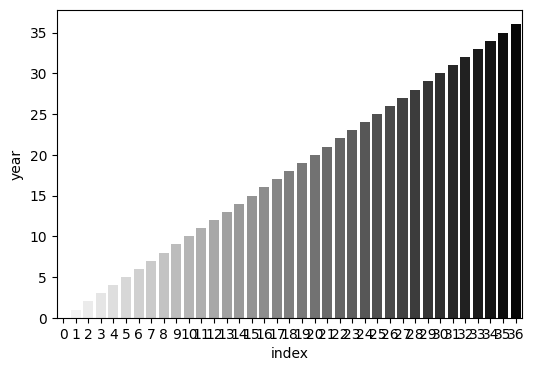

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns

df=pd.DataFrame(data=[i for i in range(len(df_tasks['year'].unique()))],columns=['year'])
table=df['year'].reset_index()
fig, ax1 = plt.subplots(figsize=(6,4))
sns.barplot(x='index', y='year', data=table, ax=ax1, palette='gist_gray_r')

bars = [r for r in ax1.get_children() if type(r)==Rectangle]
colors = [c.get_facecolor() for c in bars[:-1]]
colors = [f"rgb({c[0]},{c[1]},{c[2]})" for c in colors]

In [69]:
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py

In [71]:
task_rename = {
    'earthworks': 'Terraplanagem',
    'concrete': 'Concretagem',
    'formworks': 'Cofragem',
    'steelworks': 'Siderurgia',
    'outdoor': 'Pinturas exteriores',
    'pavements': 'Pavimentação de asfalto'
}

In [81]:
fig = (
    df_tasks
    .melt(
        id_vars=['year', 'month'],
        value_vars=[
            'earthworks', 'concrete', 'formworks',
            'steelworks', 'outdoor', 'pavements'],
        var_name='Tarefa'
    )
    .groupby(['year', 'month', 'Tarefa'])
    .agg(working_days = ('value', 'mean'))
    .reset_index()
    .assign(
        order = lambda df: np.select([
            (df['Tarefa'] == 'earthworks'),
            (df['Tarefa'] == 'formworks'),
            (df['Tarefa'] == 'steelworks'),
            (df['Tarefa'] == 'concrete'),
            (df['Tarefa'] == 'outdoor'),
            (df['Tarefa'] == 'pavements')
            ],
            [0, 1, 2, 3, 4, 5]
            ),
        Tarefa = lambda df: df['Tarefa'].apply(lambda v: task_rename[v]),
        month = lambda df: df['month'].astype(int)
    )
    .sort_values(['order', 'year', 'month'])
    .rename(columns={
        'working_days': 'Dias trabalhados (%)',
        'year': 'Ano',
        'month': 'Mês'
    })
    .pipe(lambda df: (
        px.line(
            df, x='Mês', y='Dias trabalhados (%)', color='Ano',
            template="simple_white",
            color_discrete_sequence=colors,
            facet_col='Tarefa', facet_col_wrap=2)
    ))
)
fig.update_layout(
    yaxis_range=[0,1],
    width=600, height=900,
    margin=dict(t=50),
    legend=dict(
        traceorder="reversed" # this is default
    )
    # legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1)
    )
fig.write_image("real_bytask_dados.pdf")

In [102]:
for task in tasks:
    row = task_rename[task]
    for param in ['alpha', 'smoothing', 'mc', 'cossine']:
        row += f" & {bytask_weather_pert_hpt_best[f'{task}_1'][param]}"
    row += ' \\\\'
    print(row)

Terraplanagem & 0.85 & 7 & False & True \\
Concretagem & 0.85 & 0 & False & False \\
Siderurgia & 1.0 & 7 & False & False \\
Cofragem & 1.0 & 7 & False & False \\
Pavimentação de asfalto & 1.0 & 3 & False & False \\
Pinturas exteriores & 0.95 & 0 & False & False \\


In [88]:
model = WeatherPert.by_task(bytask_weather_pert_hpt_best, column_date=date_column)
model.fit(tasks_conditions=tasks_conditions, data=data[data['date'] < '2019-01-01'])

In [89]:
x = list(range(1, 60)) + [59.5] + list(range(60, 366))
thetas = model.theta
task_rename = {
    'earthworks': 'Terraplanagem',
    'concrete': 'Concretagem',
    'formworks': 'Cofragem',
    'steelworks': 'Siderurgia',
    'outdoor': 'Pinturas exteriores',
    'pavements': 'Pavimentação de asfalto'
}
fig = (
    pd.DataFrame([
        [x[i], task_rename[task.replace('_1', '')], t]
        for j, (task, theta) in enumerate(thetas.items())
            if j < len(thetas)/2
        for i, t in enumerate(theta)
        ], columns = ['Dia do ano', 'Tarefa', 'theta']
    ).pipe(lambda df: (
        px.line(
            df, x='Dia do ano', y='theta', color='Tarefa',
            template="simple_white", # color_discrete_sequence=colors,
            #facet_col='fi', facet_col_wrap=2
            )
    )))
fig.update_layout(
    yaxis_range=[0,1],
    width=800, height=600,
    yaxis_title=r'$\widehat \theta_{t,i}$',
    xaxis_title=r'$i$'
    )
fig.write_image("exp_bytask_thetas.pdf")